<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/BIGGAN_birds_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [260]:
!pip install tensorflow-gan tensorflow-addons -q
!rm -rf sample_data
# !rm -rf checkpoints samples
# !mkdir checkpoints samples

In [261]:
import tensorflow.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Embedding
from tensorflow.keras.layers import Wrapper, AveragePooling2D, LeakyReLU, BatchNormalization, UpSampling2D, GlobalAveragePooling2D, Reshape
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import os
import time
from IPython import display
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
from tqdm import tqdm 
import tensorflow_addons as tfa
# from tensorflow_addons.layers import SpectralNormalization //not working

from google.colab import drive, auth

print(tf.__version__)

2.9.2


In [262]:
#@title TPU CONFIG

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [315]:
#@title CONFIG

IMAGE_SIZE = 64
DATASET_SIZE = 13262
BUFFER_SIZE = DATASET_SIZE
BATCH_SIZE = 32
EPOCHS = 200
LATENT_DIM = 120
CHECKPOINT_DIR = 'checkpoints'
SAMPLES_DIR = 'samples'
CHECKPOINT_INTERVAL = 10
SEED = 1
NUM_CLASSES = 100
TFRECORD_PATH = 'gs://brids-xarvel/*.tfrec'
SAMPLE_INTERVAL = 5

GENERATOR_LR = 0.0001
DISCRIMINATOR_LR = 0.0004
ADAM_BETA_1 = 0.0
ADAM_BETA_2 = 0.99
ADAM_EPSILON = 1e-07

In [264]:
weight_initializer = tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02, seed=SEED
)
weight_regularizer = None
weight_regularizer_fully = None

In [265]:
#@title Dataset

def preprocess_image(img):
    return tf.cast(img, tf.float32) / 127.5 - 1.

def get_tfrecord_dataset(
    batch_size: int,
    tfrecord_path: str,
    is_training: bool,
    *,
    image_size: int,
):
    def parse_example(proto):
        features = {
          "image": tf.io.FixedLenFeature([], tf.string), 
          'height': tf.io.FixedLenFeature([], tf.int64),
          'width': tf.io.FixedLenFeature([], tf.int64),
          'channels': tf.io.FixedLenFeature([], tf.int64),
          'label_text': tf.io.FixedLenFeature([], tf.string), 
          'label_onehot':  tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
          'label_number': tf.io.FixedLenFeature([], tf.int64),
        }

        parsed = tf.io.parse_single_example(
            serialized=proto,
            features=features
        )

        image, label = parsed["image"], parsed["label_number"]
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (image_size, image_size))
    
        return image, label
    
    tfrecord_files = tf.io.gfile.glob(tfrecord_path)

    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_example)
    if is_training:
      dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True, seed=SEED)
      dataset = dataset.repeat()

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(lambda image, label: (preprocess_image(image), label))
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
   
    return dataset

train_dataset = get_tfrecord_dataset(
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=False
) 

In [266]:
#@title SpectralNormalization


class SpectralNormalization(Wrapper):
    """
    Attributes:
       layer: tensorflow keras layers (with kernel attribute)
    """

    def __init__(self, layer, **kwargs):
        super(SpectralNormalization, self).__init__(layer, **kwargs)

    def build(self, input_shape):
        """Build `Layer`"""

        if not self.layer.built:
            self.layer.build(input_shape)

            if not hasattr(self.layer, 'kernel'):
                raise ValueError(
                    '`SpectralNormalization` must wrap a layer that'
                    ' contains a `kernel` for weights')

            self.w = self.layer.kernel
            self.w_shape = self.w.shape.as_list()
            self.u = self.add_weight(
                shape=tuple([1, self.w_shape[-1]]),
                initializer=k.initializers.TruncatedNormal(stddev=0.02),
                name='sn_u',
                trainable=False,
                dtype=tf.float32)

        super(SpectralNormalization, self).build()

    @tf.function
    def call(self, inputs):
        """Call `Layer`"""
        # Recompute weights for each forward pass
        self._compute_weights()
        output = self.layer(inputs)
        return output

    def _compute_weights(self):
        """Generate normalized weights.
        This method will update the value of self.layer.kernel with the
        normalized value, so that the layer is ready for call().
        """
        w_reshaped = tf.reshape(self.w, [-1, self.w_shape[-1]])
        eps = 1e-12
        _u = tf.identity(self.u)
        
        _v = tf.matmul(_u, tf.transpose(w_reshaped))
        _v = _v / tf.maximum(tf.reduce_sum(_v**2)**0.5, eps)
        _u = tf.matmul(_v, w_reshaped)
        _u = _u / tf.maximum(tf.reduce_sum(_u**2)**0.5, eps)

        self.u.assign(_u)
        sigma = tf.matmul(tf.matmul(_v, w_reshaped), tf.transpose(_u))

        self.layer.kernel = self.w / sigma

    def compute_output_shape(self, input_shape):
        return tf.TensorShape(
            self.layer.compute_output_shape(input_shape).as_list())

In [267]:
#@title ConditionalBatchNormalization

class ConditionalBatchNormalization(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(ConditionalBatchNormalization, self).__init__(**kwargs)
    
  def build(self, input_shape):
    batch, height, width, channels = input_shape
   
    self.linear_gamma = SpectralNormalization(tf.keras.layers.Dense(channels, 
			kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully,
			use_bias = False,
			name = 'linear_gamma'))
    self.linear_beta = SpectralNormalization(tf.keras.layers.Dense(channels, 
			kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully,
			use_bias = False,
			name = 'linear_beta'))
    self.batchnorm = tf.keras.layers.BatchNormalization()

  def call(self, x, c, training=False):
    x = self.batchnorm(x, training=training)
    gamma = self.linear_gamma(c, training=training)  
    beta = self.linear_beta(c, training=training)

    return x * gamma[:, None, None] + beta[:, None, None]  

In [268]:
#@title SelfAttention

class SelfAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(SelfAttention, self).__init__()

    def build(self, input_shape):
        in_channels = int(input_shape[-1])

        self.conv_theta =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels//8, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.conv_phi =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels//8, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.conv_g =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels//2, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.conv_attn =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.sigma = self.add_weight('sigma', shape=[], initializer=tf.zeros_initializer())

    def call(self, x, training=None):
        batch_size, h, w, in_channels = map(int, x.shape.as_list())
        location_num = h*w
        downsampled_num = location_num//4

        theta = self.conv_theta(x, training=training)
        theta = tf.reshape(theta, [batch_size, location_num, in_channels//8])

        phi = self.conv_phi(x, training=training)
        phi = tf.nn.max_pool(phi, ksize=[2, 2], strides=2, padding='VALID')
        phi = tf.reshape(phi, [batch_size, downsampled_num, in_channels//8])

        attn = tf.matmul(theta, phi, transpose_b=True)
        attn = tf.nn.softmax(attn)

        g = self.conv_g(x, training=training)
        g = tf.nn.max_pool(g, ksize=[2, 2], strides=2, padding='VALID')
        g = tf.reshape(g, [batch_size, downsampled_num, in_channels//2])

        attn_g = tf.matmul(attn, g)
        attn_g = tf.reshape(attn_g, [batch_size, h, w, in_channels//2])
        attn_g = self.conv_attn(attn_g, training=training)

        return x + self.sigma * attn_g

In [269]:
#@title DBlock

class DBlock(Model):
  def __init__(self, channels, downsample=True, preactivation=True):
    super(DBlock, self).__init__()
    self.out_channels = channels
    self.hidden_channels = self.out_channels 
    self.activation1 = tf.keras.layers.ReLU()
    self.activation2 = tf.keras.layers.ReLU()
    self.conv33_1 = SpectralNormalization(Conv2D(filters=self.hidden_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.conv33_2 = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.av_pool_1 = AveragePooling2D(padding='same')
    self.av_pool_2 = AveragePooling2D(padding='same')
    
    self.downsample = downsample
    self.preactivation = preactivation
  
  def build(self, input_shape):
    batch, height, width, channels = input_shape
    self.in_channels = channels
    self.learnable_sc = True if (self.in_channels != self.out_channels) or self.downsample else False

    if self.learnable_sc:
      self.conv_sc = tfa.layers.SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=1, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))

  def shortcut(self, x, training=False):
    if self.preactivation:
      if self.learnable_sc:
        x = self.conv_sc(x, training=training)
      if self.downsample:
        x = self.av_pool_1(x)
    else:
      if self.downsample:
        x = self.av_pool_1(x)
      if self.learnable_sc:
        x = self.conv_sc(x, training=training)
    return x

  def call(self, x, training=False):
    if self.preactivation:
      h = self.activation1(x)
    else:
      h = x    

    h = self.conv33_1(h, training=training)
    h = self.conv33_2(self.activation2(h), training=training)

    if self.downsample:
      h = self.av_pool_2(h)     
        
    return h + self.shortcut(x, training=training)           


In [270]:
#@title GBlock

class GBlock(Model):
  def __init__(self, channels):
    super(GBlock, self).__init__()
    self.out_channels = channels
    self.bn1 = ConditionalBatchNormalization()
    self.bn2 = ConditionalBatchNormalization()
    self.up_sample_1 = UpSampling2D()
    self.up_sample_2 = UpSampling2D()
    self.activation1 = tf.keras.layers.ReLU()
    self.activation2 = tf.keras.layers.ReLU()
    self.conv33_1 = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.conv33_2 = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.upsample = True

  def build(self, input_shape):
    batch, height, width, channels = input_shape
    self.in_channels = channels
    self.learnable_sc = self.in_channels != self.out_channels

    if self.learnable_sc:
      self.conv_sc = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=1, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
      
  def call(self, x, label, training=False):
    h = self.activation1(self.bn1(x, label, training=training))
    if self.upsample:
      h = self.up_sample_1(h)
      x = self.up_sample_2(x)

    h = self.conv33_1(h, training=training)
    h = self.activation2(self.bn2(h, label, training=training))
    h = self.conv33_2(h, training=training)

    if self.learnable_sc:       
      x = self.conv_sc(x, training=training)

    return h + x

In [271]:
#@title Generator

class Generator(Model):
  def __init__(self, channels, num_classes, embedding_size):
    super(Generator, self).__init__()
    self.channels = channels
    self.linear = SpectralNormalization(Dense(4 * 4 * 16 * channels, use_bias=False, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully))
    self.reshape = Reshape([4, 4, 16 * channels])

    self.res_block_1 = GBlock(16 * channels)
    self.res_block_2 = GBlock(16 * channels)
    self.res_block_3 = GBlock(8 * channels)
    self.attention = SelfAttention()
    self.res_block_4 = GBlock(4 * channels)

    self.embedding = Embedding(num_classes, embedding_size, embeddings_initializer=weight_initializer)

    self.bn = BatchNormalization()
    self.activation = tf.keras.layers.ReLU()
    self.conv = SpectralNormalization(Conv2D(filters=3, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.concat = tf.keras.layers.Concatenate();

  @tf.function
  def call(self, z, label, training=False):    
    z_split = tf.split(z, num_or_size_splits=5, axis=-1)
    embed = self.embedding(label)
    conds = [self.concat([z_i, embed]) for z_i in z_split[1:]]
    x = self.linear(z_split[0], training=training)
    x = self.reshape(x)
    x = self.res_block_1(x, conds[0], training=training)
    x = self.res_block_2(x, conds[1], training=training)
    x = self.res_block_3(x, conds[2], training=training)
    x = self.attention(x, training=training)
    x = self.res_block_4(x, conds[3], training=training)
    x = self.bn(x, training=training)
    x = self.activation(x)
    x = self.conv(x, training=training)
    return tf.nn.tanh(x)

In [273]:
#@title Discriminator

class Discriminator(Model):
  def __init__(self, channels, num_classes):
    super(Discriminator, self).__init__()
    self.res_block_1 = DBlock(1 * channels, downsample=True, preactivation=False)
    self.res_block_2 = DBlock(2 * channels, downsample=True, preactivation=True)
    self.res_block_3 = DBlock(4 * channels, downsample=True, preactivation=True)
    self.res_block_4 = DBlock(8 * channels, downsample=True, preactivation=True)
    self.attention = SelfAttention()
    self.res_block_5 = DBlock(16 * channels, downsample=False, preactivation=True)
    self.activation = tf.keras.layers.ReLU()
    self.embedding = Embedding(num_classes, 16 * channels, embeddings_initializer=weight_initializer)

    self.linear = SpectralNormalization(
       Dense(1, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully)
    )
  
  @tf.function
  def call(self, x, label, training=False):
    x = self.res_block_1(x, training=training)
    x = self.res_block_2(x, training=training)
    x = self.res_block_3(x, training=training)
    x = self.res_block_4(x, training=training)
    x = self.attention(x, training=training)
    x = self.res_block_5(x, training=training)
    x = self.activation(x)
    x = tf.reduce_sum(x, axis=[1, 2])
    out = self.linear(x, training=training)
    embed = self.embedding(label)
    out += tf.reduce_sum(x * embed, axis=-1, keepdims=True)
    return out

In [274]:
with strategy.scope():
  generator = Generator(64, num_classes=NUM_CLASSES, embedding_size=LATENT_DIM)
  discriminator = Discriminator(64, num_classes=NUM_CLASSES)

In [275]:
per_replica_batch_size = BATCH_SIZE // strategy.num_replicas_in_sync

train_dataset = strategy.distribute_datasets_from_function(
    lambda _: get_tfrecord_dataset(
    batch_size=per_replica_batch_size,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=True
))

In [276]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_hinge_loss(logits_real: tf.Tensor, logits_fake: tf.Tensor) -> tf.Tensor:
  L_D = -tf.reduce_mean(tf.minimum(0., -1.0 + logits_real)) - tf.reduce_mean(tf.minimum(0., -1.0 - logits_fake))

  return L_D    

def generator_hinge_loss(logits_fake: tf.Tensor) -> tf.Tensor:
    L_G = -tf.reduce_mean(logits_fake)
    return L_G  

In [277]:
with strategy.scope():
  generator_optimizer = tf.keras.optimizers.Adam(
      learning_rate=GENERATOR_LR, 
      beta_1=ADAM_BETA_1, 
      beta_2=ADAM_BETA_2,
      epsilon=ADAM_EPSILON
  )
  discriminator_optimizer = tf.keras.optimizers.Adam(
      learning_rate=DISCRIMINATOR_LR, 
      beta_1=ADAM_BETA_1, 
      beta_2=ADAM_BETA_2, 
      epsilon=ADAM_EPSILON
  )

In [278]:
fixed_noise = tf.random.truncated_normal((100, LATENT_DIM), stddev=1)

def sample_images(epoch):
  rows = 10
  cols = 10

  noise = fixed_noise

  labels = np.arange(0, 100)
  gen_imgs = generator(noise, labels)
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  fig.subplots_adjust(wspace=0.01, hspace=0)

  fig.set_figheight(100)
  fig.set_figwidth(100)
  fig.set_tight_layout(True)
 
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(gen_imgs[j * 10 + i])
  
      axs[i,j].axis('off')

  # Create folder if not exits
  if not os.path.isdir(SAMPLES_DIR):
    os.makedirs(SAMPLES_DIR, exist_ok=True)

  plt.savefig(SAMPLES_DIR + '/image_at_epoch_{:04d}.png'.format(epoch))
  plt.close(fig)

def show_analytics(meta, save=False):
  history = meta['history']

  with plt.xkcd():
    fig, axs = plt.subplots(figsize=(10,10))
    plt.plot(history['gen_loss'], label='Generator loss')
    plt.plot(history['disc_loss'], label='Discriminator loss')
    plt.title('Learing process')
    
    plt.figtext(.7, .17, '\n'.join([
        'Epoch=%s' % meta['epoch'],
        "GEN_LR=%s" % GENERATOR_LR,
        'DISC_LR=%s' % DISCRIMINATOR_LR,
        'BATCH_SIZE=%s' % BATCH_SIZE
    ]))

    fig.legend();
    if save:
      fig.savefig(SAMPLES_DIR + '/analytics_at_epoch_{:04d}.png'.format(meta['epoch'])) 
      plt.close(fig)   

In [279]:
#@title train_step

with strategy.scope():
  d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
  g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

@tf.function
def train_step(iterator):
  """The step function for one training step."""

  def step_fn(inputs):
    """The computation to run on each TPU device."""
    images, labels = inputs
    noise = tf.random.normal([per_replica_batch_size, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, labels, training=True)
      gen_predictions = discriminator(generated_images, labels, training=True)
      real_predictions = discriminator(images, labels, training=True)
      disc_loss = discriminator_hinge_loss(real_predictions, gen_predictions)
      gen_loss = generator_hinge_loss(gen_predictions)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))
 
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_weights)
    discriminator_optimizer.apply_gradients(
      zip(gradients_of_discriminator, discriminator.trainable_weights)
    )
    
    d_loss_metric.update_state(disc_loss)
    g_loss_metric.update_state(gen_loss)
    
    return disc_loss, gen_loss

  disc_loss, gen_loss = strategy.run(step_fn, args=(next(iterator),))

  disc_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, disc_loss, axis=None)
  gen_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, gen_loss, axis=None)
  
  return disc_loss, gen_loss

In [280]:
#@title checkpoint
import json

with strategy.scope():
  current_epoch = tf.Variable(1);

checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")
latest_checkpoint = tf.train.latest_checkpoint(CHECKPOINT_DIR)

defaultMeta = {
    "history": {
        "disc_loss": [],
        "gen_loss": []
    },
    "epoch": 1
}
meta = defaultMeta

META_FILE = CHECKPOINT_DIR + '/meta.json'

def restore_checkpoint():
  try:
    with open(META_FILE) as f:
      meta = json.load(f)
  except:
    meta = defaultMeta
    pass
  
  status = checkpoint.restore(latest_checkpoint, options=local_device_option)
  return meta

def save_checkpoint():
  print('Saving checkpoint');

  # Create folder if not exits
  if not os.path.isdir(SAMPLES_DIR):
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

  with open(META_FILE, 'w') as f:
    json.dump(meta, f)
  
  checkpoint_prefix = os.path.join(CHECKPOINT_DIR, "ckpt")
  checkpoint.save(file_prefix = checkpoint_prefix, options=local_device_option)

meta = restore_checkpoint();

(1, 64, 64, 3)


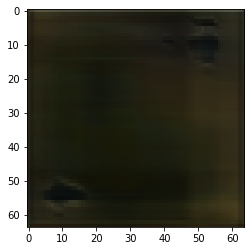

In [281]:
with strategy.scope():
  label = tf.constant([1])
  noise = tf.random.truncated_normal([1, 120], stddev=0.5)
  generated_image = generator(noise, label, training=False)
  print(generated_image.shape)
  plt.imshow(generated_image[0] * 0.5 + 0.5)  

In [282]:
with strategy.scope():
  decision = discriminator(generated_image, label)
  print(decision)

tf.Tensor([[-4.223401]], shape=(1, 1), dtype=float32)


In [283]:
steps_per_epoch = DATASET_SIZE // BATCH_SIZE
train_iterator = iter(train_dataset)

for epoch in range(meta['epoch'], EPOCHS):
  meta['epoch'] = epoch
  start = time.time()
  print('Epoch: {}/{}'.format(epoch, EPOCHS))

  pbar = tqdm(range(steps_per_epoch))
  for step in pbar:
    disc_loss, gen_loss = train_step(train_iterator)
    meta['history']['disc_loss'].append(float(disc_loss));
    meta['history']['gen_loss'].append(float(gen_loss));
    pbar.set_postfix({'disc_loss': round(float(disc_loss), 4), 'gen_loss': round(float(gen_loss), 4)})
    pbar.set_description("Current step %s" % generator_optimizer.iterations.numpy())
    
  if epoch % SAMPLE_INTERVAL == 0:
    sample_images(epoch)
    
  if epoch % CHECKPOINT_INTERVAL == 0:
    save_checkpoint()
    show_analytics(meta, save=True)   

  print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

Epoch: 95/200


  0%|          | 0/414 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("PartitionedCall_1:2", shape=(4,), dtype=int64), values=Tensor("PartitionedCall_1:1", shape=(4, 120), dtype=float32), dense_shape=Tensor("PartitionedCall_1:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("concat_1:0", shape=(8,), dtype=int64), values=Tensor("concat:0", shape=(8, 1024), dtype=float32), dense_shape=Tensor("PartitionedCall_2:59", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % 

Time for epoch 96 is 331.7132353782654 sec
Epoch: 96/200


Current step 40158: 100%|██████████| 414/414 [00:36<00:00, 11.32it/s, disc_loss=0.356, gen_loss=2.04]


Time for epoch 97 is 36.58465814590454 sec
Epoch: 97/200


Current step 40572: 100%|██████████| 414/414 [00:36<00:00, 11.25it/s, disc_loss=0.068, gen_loss=2.56]


Time for epoch 98 is 36.79788780212402 sec
Epoch: 98/200


Current step 40986: 100%|██████████| 414/414 [00:36<00:00, 11.29it/s, disc_loss=0.28, gen_loss=2.68]


Time for epoch 99 is 36.68789315223694 sec
Epoch: 99/200


Current step 41400: 100%|██████████| 414/414 [00:36<00:00, 11.28it/s, disc_loss=0.272, gen_loss=2.28]


Time for epoch 100 is 36.69319415092468 sec
Epoch: 100/200


Current step 41814: 100%|██████████| 414/414 [00:36<00:00, 11.26it/s, disc_loss=0.502, gen_loss=2.99]


Saving checkpoint
Time for epoch 101 is 55.39796209335327 sec
Epoch: 101/200


Current step 42228: 100%|██████████| 414/414 [00:36<00:00, 11.27it/s, disc_loss=0.39, gen_loss=3.42]


Time for epoch 102 is 36.74169182777405 sec
Epoch: 102/200


Current step 42642: 100%|██████████| 414/414 [00:36<00:00, 11.27it/s, disc_loss=0.497, gen_loss=3.13]


Time for epoch 103 is 36.73412895202637 sec
Epoch: 103/200


Current step 43056: 100%|██████████| 414/414 [00:36<00:00, 11.28it/s, disc_loss=0.162, gen_loss=2.77]


Time for epoch 104 is 36.70607376098633 sec
Epoch: 104/200


Current step 43470: 100%|██████████| 414/414 [00:36<00:00, 11.26it/s, disc_loss=0.244, gen_loss=1.8]


Time for epoch 105 is 36.77336812019348 sec
Epoch: 105/200


Current step 43884: 100%|██████████| 414/414 [00:36<00:00, 11.24it/s, disc_loss=0.388, gen_loss=1.73]


Time for epoch 106 is 50.998114585876465 sec
Epoch: 106/200


Current step 44298: 100%|██████████| 414/414 [00:36<00:00, 11.25it/s, disc_loss=0.455, gen_loss=1.48]


Time for epoch 107 is 36.80999803543091 sec
Epoch: 107/200


Current step 44712: 100%|██████████| 414/414 [00:36<00:00, 11.22it/s, disc_loss=0.621, gen_loss=1.17]


Time for epoch 108 is 36.920620918273926 sec
Epoch: 108/200


Current step 45126: 100%|██████████| 414/414 [00:36<00:00, 11.28it/s, disc_loss=0.455, gen_loss=3.38]


Time for epoch 109 is 36.710814237594604 sec
Epoch: 109/200


Current step 45540: 100%|██████████| 414/414 [00:36<00:00, 11.19it/s, disc_loss=0.303, gen_loss=2.71]


Time for epoch 110 is 36.98812007904053 sec
Epoch: 110/200


Current step 45954: 100%|██████████| 414/414 [00:36<00:00, 11.22it/s, disc_loss=0.489, gen_loss=2.58]


Saving checkpoint
Time for epoch 111 is 56.10546064376831 sec
Epoch: 111/200


Current step 46368: 100%|██████████| 414/414 [00:37<00:00, 11.17it/s, disc_loss=0.207, gen_loss=2.23]


Time for epoch 112 is 37.07143425941467 sec
Epoch: 112/200


Current step 46782: 100%|██████████| 414/414 [00:36<00:00, 11.34it/s, disc_loss=0.447, gen_loss=3.43]


Time for epoch 113 is 36.526043176651 sec
Epoch: 113/200


Current step 47196: 100%|██████████| 414/414 [00:36<00:00, 11.31it/s, disc_loss=0.151, gen_loss=2.06]


Time for epoch 114 is 36.62334847450256 sec
Epoch: 114/200


Current step 47610: 100%|██████████| 414/414 [00:36<00:00, 11.33it/s, disc_loss=0.337, gen_loss=3.21]


Time for epoch 115 is 36.53160309791565 sec
Epoch: 115/200


Current step 48024: 100%|██████████| 414/414 [00:36<00:00, 11.30it/s, disc_loss=0.9, gen_loss=3.52]


Time for epoch 116 is 52.15886688232422 sec
Epoch: 116/200


Current step 48438: 100%|██████████| 414/414 [00:36<00:00, 11.33it/s, disc_loss=0.217, gen_loss=2.22]


Time for epoch 117 is 36.543521881103516 sec
Epoch: 117/200


Current step 48852: 100%|██████████| 414/414 [00:36<00:00, 11.32it/s, disc_loss=0.231, gen_loss=2.73]


Time for epoch 118 is 36.583012342453 sec
Epoch: 118/200


Current step 49266: 100%|██████████| 414/414 [00:36<00:00, 11.30it/s, disc_loss=0.308, gen_loss=2.92]


Time for epoch 119 is 36.63695001602173 sec
Epoch: 119/200


Current step 49680: 100%|██████████| 414/414 [00:36<00:00, 11.26it/s, disc_loss=0.346, gen_loss=1.3]


Time for epoch 120 is 36.783371686935425 sec
Epoch: 120/200


Current step 50094: 100%|██████████| 414/414 [00:36<00:00, 11.27it/s, disc_loss=0.203, gen_loss=2.11]


Saving checkpoint
Time for epoch 121 is 55.84162735939026 sec
Epoch: 121/200


Current step 50508: 100%|██████████| 414/414 [00:36<00:00, 11.39it/s, disc_loss=0.324, gen_loss=1.87]


Time for epoch 122 is 36.36376929283142 sec
Epoch: 122/200


Current step 50922: 100%|██████████| 414/414 [00:36<00:00, 11.32it/s, disc_loss=0.29, gen_loss=3.47]


Time for epoch 123 is 36.5621771812439 sec
Epoch: 123/200


Current step 51336: 100%|██████████| 414/414 [00:36<00:00, 11.30it/s, disc_loss=0.797, gen_loss=0.538]


Time for epoch 124 is 36.64089298248291 sec
Epoch: 124/200


Current step 51750: 100%|██████████| 414/414 [00:36<00:00, 11.35it/s, disc_loss=0.811, gen_loss=3.25]


Time for epoch 125 is 36.465856075286865 sec
Epoch: 125/200


Current step 51809:  14%|█▍        | 59/414 [00:05<00:31, 11.19it/s, disc_loss=0.285, gen_loss=2.65]


KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


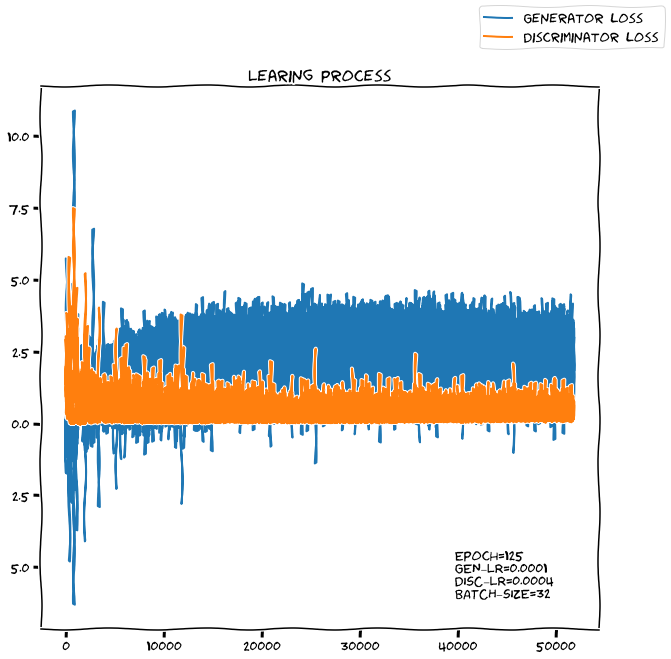

In [325]:
show_analytics(meta, save=False)    